Mean traditional E[V30]: 34828.97696028555
Standard Deviation traditional: 232.2870564068171
1%-Quantile F^-1_V30(0.01) traditional: 34364.16933004447
Mean E[V30] cpp: 34549.86325290095
Standard Deviation cpp: 403.7094748581954
1%-Quantile F^-1_V30(0.01) cpp: 33823.52462881842


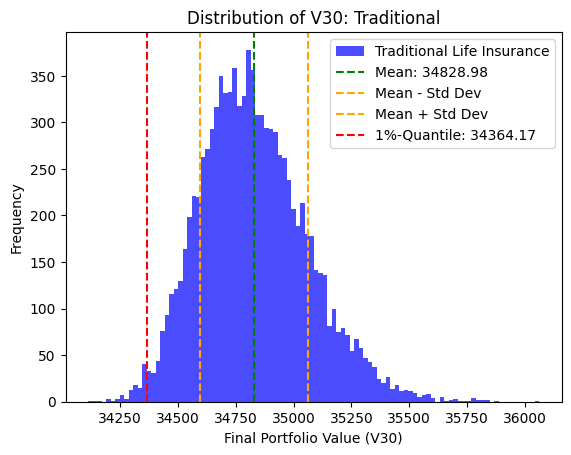

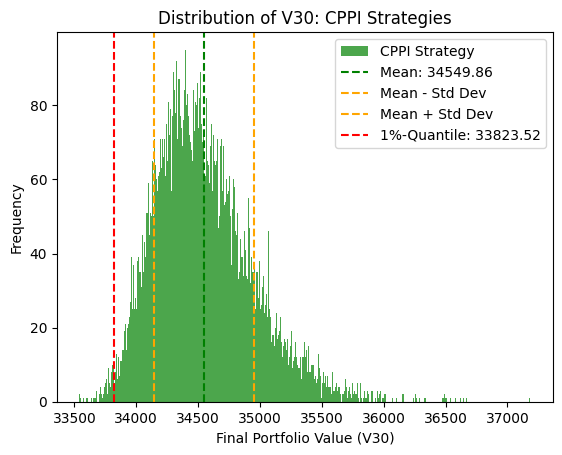

In [ ]:
#For c and d

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load empirical returns from a dataset (replace with your actual data loading logic)
file_path = 'fonddata.csv'
fonddata = pd.read_csv(file_path, delimiter=';', thousands=',')
fonddata['Date'] = pd.to_datetime(fonddata['Date'])
closing_prices = fonddata['Closing price'].values
monthly_returns = np.diff(closing_prices) / closing_prices[:-1]  # Percentage changes
monthly_returns = monthly_returns[~np.isnan(monthly_returns)]  # Remove NaNs
monthly_returns = monthly_returns[monthly_returns != 0]  # Remove zero returns if any

# Parameters
years = 30
annual_investment = 1000
r_bar = 0.005
risk_free_rate = 0.01
num_simulations = 10000

# Function to calculate guaranteed amount G_k
def calculate_guaranteed(k, r_bar):
    return annual_investment * np.sum([np.exp(r_bar * j) for j in range(1, k + 1)])

# Function to create random annual returns by grouping 12 random months
def simulate_annual_returns_from_monthly(monthly_returns, n_years, n_simulations):
    """
    Simulates annual returns by compounding 12 randomly sampled monthly returns.
    """
    np.random.seed(42)  # For reproducibility
    simulated_returns = np.zeros((n_simulations, n_years))

    for sim in range(n_simulations):
        for year in range(n_years):
            # Randomly sample 12 months and calculate compounded annual return
            sampled_months = np.random.choice(monthly_returns, 12, replace=True)
            annual_return = np.prod(1 + sampled_months) - 1  # Compound 12 months
            simulated_returns[sim, year] = annual_return

    return simulated_returns

# Simulation of traditional life insurance strategy
def simulate_traditional_strategy(monthly_returns):
    simulated_annual_returns = simulate_annual_returns_from_monthly(monthly_returns, years, num_simulations)
    final_values = []

    for sim in range(num_simulations):
        G_k = 0
        V_k = 0

        for k in range(1, years + 1):
            G_k = calculate_guaranteed(k, r_bar)
            bond_investment = G_k * np.exp(-risk_free_rate)
            risky_investment = V_k + annual_investment - bond_investment

            # Update portfolio value
            annual_return = simulated_annual_returns[sim, k - 1]
            V_k = bond_investment * np.exp(risk_free_rate) + risky_investment * (1 + annual_return)

        final_values.append(V_k)

    return np.array(final_values)

# Simulation of CPPI strategy with leverage
def simulate_cpp_strategy(monthly_returns):
    simulated_annual_returns = simulate_annual_returns_from_monthly(monthly_returns, years, num_simulations)
    final_values = []

    for sim in range(num_simulations):
        G_k = 0
        V_k = 0

        for k in range(1, years + 1):
            G_k = calculate_guaranteed(k, r_bar)
            surplus = V_k + annual_investment - G_k * np.exp(-risk_free_rate)
            
            if surplus > 0:
                # Apply leverage of 2 on the surplus
                risky_investment = 2 * surplus
                bond_investment = V_k + annual_investment - risky_investment
            else:
                # Invest entirely in the bond if falling behind the guarantee
                bond_investment = V_k + annual_investment
                risky_investment = 0

            # Update portfolio value
            annual_return = simulated_annual_returns[sim, k - 1]
            V_k = bond_investment * np.exp(risk_free_rate) + risky_investment * (1 + annual_return)

        final_values.append(V_k)

    return np.array(final_values)

# Run simulations
traditional_values = simulate_traditional_strategy(monthly_returns)
cppi_values = simulate_cpp_strategy(monthly_returns)

# Calculate metrics for traditional strategy
mean_traditional = np.mean(traditional_values)
std_traditional = np.std(traditional_values)
one_percentile_traditional = np.percentile(traditional_values, 1)

# Calculate metrics for CPPI strategy
mean_cpp = np.mean(cppi_values)
std_cpp = np.std(cppi_values)
one_percentile_cpp = np.percentile(cppi_values, 1)

# Print results
print(f"Mean traditional E[V30]: {mean_traditional}")
print(f"Standard Deviation traditional: {std_traditional}")
print(f"1%-Quantile F^-1_V30(0.01) traditional: {one_percentile_traditional}")
print(f"Mean E[V30] cpp: {mean_cpp}")
print(f"Standard Deviation cpp: {std_cpp}")
print(f"1%-Quantile F^-1_V30(0.01) cpp: {one_percentile_cpp}")

# Plot histograms
plt.figure()
plt.hist(traditional_values, bins=100, alpha=0.7, color='blue', label='Traditional Life Insurance')
plt.axvline(mean_traditional, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_traditional:.2f}')
plt.axvline(mean_traditional - std_traditional, color='orange', linestyle='--', linewidth=1.5, label=f'Mean - Std Dev')
plt.axvline(mean_traditional + std_traditional, color='orange', linestyle='--', linewidth=1.5, label=f'Mean + Std Dev')
plt.axvline(one_percentile_traditional, color='red', linestyle='--', linewidth=1.5, label=f'1%-Quantile: {one_percentile_traditional:.2f}')

plt.xlabel('Final Portfolio Value (V30)')
plt.ylabel('Frequency')
plt.title('Distribution of V30: Traditional')
plt.legend()
plt.show()

plt.figure()
plt.hist(cppi_values, bins=500, alpha=0.7, color='green', label='CPPI Strategy')
plt.axvline(mean_cpp, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_cpp:.2f}')
plt.axvline(mean_cpp - std_cpp, color='orange', linestyle='--', linewidth=1.5, label=f'Mean - Std Dev')
plt.axvline(mean_cpp + std_cpp, color='orange', linestyle='--', linewidth=1.5, label=f'Mean + Std Dev')
plt.axvline(one_percentile_cpp, color='red', linestyle='--', linewidth=1.5, label=f'1%-Quantile: {one_percentile_cpp:.2f}')

plt.xlabel('Final Portfolio Value (V30)')
plt.ylabel('Frequency')
plt.title('Distribution of V30: CPPI Strategies')
plt.legend()
plt.show()


